# Statistics studies

<br>
Created: 03.01.2024<br>
Melih Kara

Following the same lecture, practicing statistics. <br>
https://indico.desy.de/event/38671/contributions/140932/attachments/83039/109605/2023_07_03_Statisticsschool_DESY_with_solutions.pdf

In [1]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import uproot
import scipy
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm

In [2]:
rootfile = uproot.open("./StatTutorial-master/data/Histograms_fake.root")
higgs_expected = rootfile['h_m4l_Higgs125_fake;1'].to_numpy()
bg_expected = rootfile['h_m4l_ZZ_fake;1'].to_numpy()
observed_data = rootfile['h_m4l_data_fake;1'].to_numpy()

energies = higgs_expected[1][1:]
higgs_expected = higgs_expected[0]
bg_expected = bg_expected[0]
observed_data = observed_data[0]
energies.shape, higgs_expected.shape, bg_expected.shape, observed_data.shape

((3600,), (3600,), (3600,), (3600,))

In [3]:
# rebinned data
rb_energies = energies.reshape((180,20)).mean(1)
rb_observed_data = observed_data.reshape((180,20)).sum(1)
rb_higgs_expected = higgs_expected.reshape((180,20)).sum(1)
rb_bg_expected = bg_expected.reshape((180,20)).sum(1)

optimized_window = 7.26 # GeV for luminosity scale factor of 1
# alpha_scale = 1.11 # for background model scaling  # single optimization
# sigma_p = 0.063
# sigma_m = 0.075

# parameters from multivariate fitting (errors are not computed)
alpha = 1.18
mu = 1.32 
ROI = (energies >= 125-optimized_window/2) & (energies <= 125+optimized_window/2)

$$\lambda = f_{total} = \mu\cdot f_{\rm Higgs} + \alpha\cdot f_{\rm SM}$$<br>
 $$-2\log(L) = -2\cdot\sum_{bins}\log(\text{Poisson}(N_{bin}^{data}|\lambda))$$<br>
 $$\mu = 1.32$$<br>
 $$\alpha = 1.18$$<br>
 $$(\alpha = 1.11^{+0.075}_{-0.063})$$<br>
 
 Now we are ready to move on!

In [4]:
roi_energies = energies[ROI] 

_roi_bg_expected = bg_expected[ROI] 
_roi_higgs_expected = higgs_expected[ROI] 

roi_bg_expected = _roi_bg_expected * alpha # scale bg expectation
roi_higgs_expected = _roi_higgs_expected * mu # scale higgs expectation
roi_observed_data = observed_data[ROI]

print("Expected Higgs Counts:", np.sum(roi_higgs_expected))
print("Expected BG Counts:", np.sum(roi_bg_expected))
print("Expected Total:", np.sum(roi_higgs_expected)+np.sum(roi_bg_expected))
print("Observed Total:", np.sum(roi_observed_data))

Expected Higgs Counts: 7.1070104
Expected BG Counts: 5.2798347
Expected Total: 12.386845
Observed Total: 13.0


In [5]:
# some useful definitions and functions
mu_norm = 0
normal_dist = ss.norm(mu_norm)
x = np.linspace(-5,5,10000)
normal_pdf = normal_dist.pdf(x)

pvaltosigma = lambda p: abs(normal_dist.ppf(p))
sigmatopval = lambda s: 1-normal_dist.cdf(s)

def get_nll(observed, expected):
    p = ss.poisson.pmf(k=observed.astype(int), mu=expected)
    return -2*np.sum(np.log10(p))

def func(mu=mu, alf=alpha, fHiggs=_roi_higgs_expected, fSM=_roi_bg_expected):
    return (mu*fHiggs) + (alf*fSM)

 $$-2\log(L) = -2\cdot\sum_{bins}\log(\text{Likelihood}) = -2\cdot\sum_{bins}\log(\text{Poisson}(N_{bin}^{data}| \mu\cdot f_{bin}^{Higgs} + \alpha\cdot f_{bin}^{SM}))$$<br>
 $$L(\mu=0) = -2\cdot\sum_{bins}\log(\text{Poisson}(N_{bin}^{data}| \alpha\cdot f_{bin}^{SM}))$$
  $$L(\mu=1) = -2\cdot\sum_{bins}\log(\text{Poisson}(N_{bin}^{data}| \cdot f_{bin}^{Higgs}+\alpha\cdot f_{bin}^{SM}))$$
  
So here $\mu=0$ represents the background-only hypothesis and $\mu=1$ represents Higgs+background hypothesis.

Likelihood ratio test statistic

$$X = -2\log(Q) \qquad \text{with} \qquad Q=\frac{L(\mu=1)}{L(\mu=0)}$$

a single number per dataset! 

Also notice the **profile likelihood ratio** 
$$Q(\mu) = \frac{L(\mu, \hat{\hat{\theta}}(\mu))}{L(\hat{\mu}, \hat{\theta})}$$

In [12]:
observed_total = np.sum(roi_observed_data)

expected_1 = func(mu=0, alf=1, fHiggs=_roi_higgs_expected, fSM=_roi_bg_expected)
expected_2 = func(mu=1, alf=1, fHiggs=_roi_higgs_expected, fSM=_roi_bg_expected)

nll_1 = get_nll(observed_total, expected_1)
nll_2 = get_nll(observed_total, expected_2)
Q = nll_1 / nll_2
Q

1.246810408694131

Now we create another Toy Monte Carlo and investigate the distribution of test statistic for bg-only and bg+signal hypothesis.<br>

Recipe: Take the histogram of the template (bg-only or bg+signal) at each bin, use the bin content as the mean ($\lambda$) of your Poisson distribution and sample a new fake-bin content for that bin. <br>

Get 1k toy-data sets for bg-only and get test statistic distribution <br>
Get 1k toy-data sets for bg+signal and get test statistic distribution <br>
plot the results

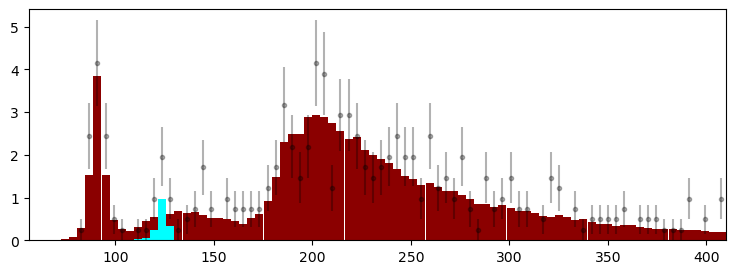

In [7]:
fig, ax = plt.subplots(figsize=(9,3))

ax.errorbar(rb_energies[rb_observed_data>0], rb_observed_data[rb_observed_data>0]/4.1, 
            yerr=np.sqrt(rb_observed_data[rb_observed_data>0])/4.1, fmt='. k', alpha=0.3)

ax.set_xlim(None, 410)
ax.set_ylim(0, None)

ax.bar(rb_energies, 1*rb_bg_expected/4.1, width=4.1, color='darkred')
ax.bar(rb_energies, 1*rb_higgs_expected/4.1, width=4.1, color='cyan')
ax.set_title(fr"");

In [8]:
Ntoys = 1000
toys_bgonly = np.array([ss.poisson(i).rvs(Ntoys) for i in rb_bg_expected])
toys_bgsig = np.array([ss.poisson(i).rvs(Ntoys) for i in rb_bg_expected+rb_higgs_expected])

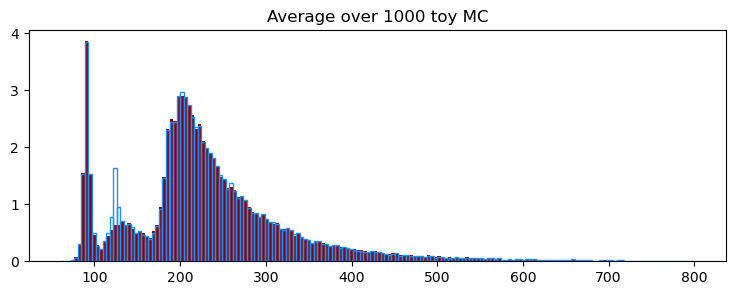

In [9]:
fig, ax = plt.subplots(figsize=(9,3))
ax.bar(rb_energies, 1*toys_bgonly.mean(-1)/4.1, width=4.1, color='darkred', label='bg only')
ax.bar(rb_energies, 1*toys_bgsig.mean(-1)/4.1, width=4.1, ec='dodgerblue', fc='none', label='bg+sig')
ax.set_title(fr"Average over {Ntoys} toy MC");

Now get the test statistic distributions and plot.

In [15]:
nll_1 = np.array([get_nll(observed_total, tbgo) for tbgo in toys_bgonly.sum(0)])
nll_2 = np.array([get_nll(observed_total, tbgs) for tbgs in toys_bgsig.sum(0)])
Q = nll_1 / nll_2
Q.shape

(1000,)

$$X = -2\log(Q) \qquad Q=\frac{L(\mu=1)}{L(\mu=0)}$$

$$X = -2(\log(L(\mu=1))-\log(L(\mu=0)))$$

In [16]:
nll_1 - nll_2

array([ -0.83655587, -20.929174  , -28.49648472, -31.77569978,
        19.23205857,  15.88918649, -30.99374617,  -9.1939016 ,
        18.41869665,  -5.0086842 , -31.83617105,   4.99644811,
       -16.70541152, -30.10674959,  15.05706122, -28.44050423,
        -1.67409588,  -3.34493717,  -2.50772005, -23.3789745 ,
        17.59142145, -25.92691464,   3.34493717, -33.48413125,
       -17.56555926,  20.92032793,  27.61745802, -45.9710685 ,
        38.41139817,  51.95079019,  16.77101757,   0.        ,
       -41.06935074,  40.95207314,  15.05706122, -20.92032793,
       -37.62222593,  13.40640447, -26.75580104, -40.97516495,
       -28.48518209, -10.87517944,  33.44796638,  -7.52229142,
        20.04874582, -24.29513983,  -6.68986584,  24.22680037,
        20.90898605,   2.51074538,   8.35277827, -20.09516661,
       -15.90460813,   1.6761418 ,  15.00322629,   1.67190805,
         0.83717961,  18.43917479, -13.39963895,  -8.36416826,
        10.04768707,  25.85334924,  35.05895208,  36.01

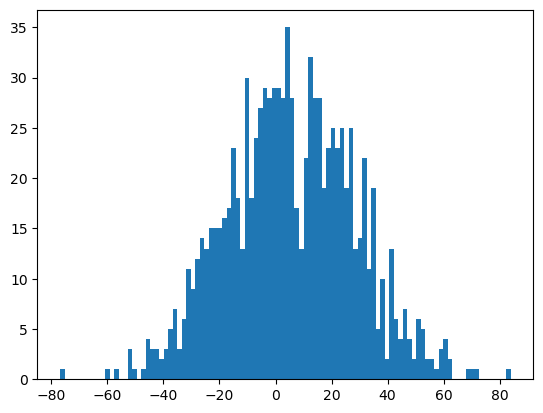

In [17]:
plt.hist(-1*(nll_1 - nll_2), bins=100);

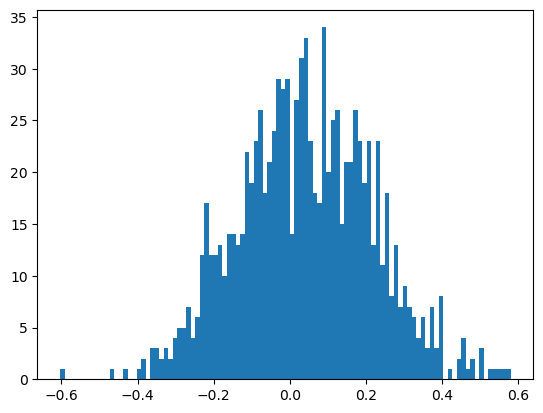

In [18]:
plt.hist(-2*np.log(Q), bins=100);